In [1]:
%pylab inline
import sklearn.feature_extraction.image
import sklearn.metrics
import os
import pyprind
#climate.enable_default_logging()
import glob
from scipy.ndimage.filters import median_filter
import datetime
import skimage.feature
import skimage.filter.rank
from skimage.morphology import disk
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

Populating the interactive namespace from numpy and matplotlib


/home/riri/.virtualenvs/deeplearning/local/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [2]:
from IPython import display

In [3]:
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

/home/riri/.virtualenvs/deeplearning/local/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


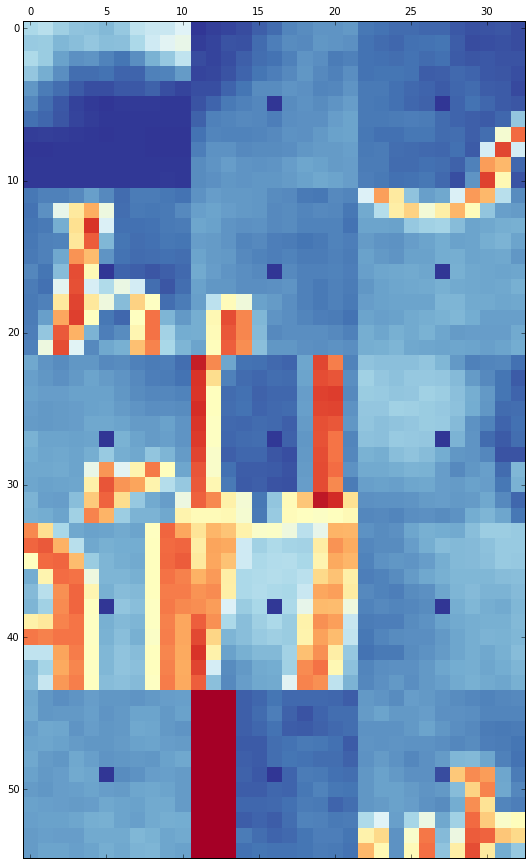

In [4]:
patch_size = 11
patch_center = patch_size / 2
max_patches = 500
n_images = 10

all_images = [int(filter(char.isdigit, image)) for image in glob.glob("train-categorized/crumpled/*.png")]
#all_train_images = [i for i in all_images if i % 6]
#all_valid_images = [i for i in all_images if not i % 6]
all_train_images = all_images
all_valid_images = all_images

def enlargen_image(image):
    enlargened_size = (image.shape[0] + patch_center*2, image.shape[1] + patch_center*2)
    enlargened_image = np.zeros(enlargened_size, dtype=np.float32)
    enlargened_image[patch_center:-patch_center, patch_center:-patch_center] = image
    return enlargened_image

def batch(mode):
    if mode == 'train':
        images = np.random.choice(all_train_images, n_images)
    else:
        images = np.random.choice(all_valid_images, n_images)

    X_patches = np.zeros((0, patch_size, patch_size))
    y_patches = np.zeros((0, patch_size, patch_size))

    for image in images:
        X_image = imread('train/%d.png' % image)
        y_image = imread('train_cleaned/%d.png' % image)

        enlargened_X = enlargen_image(X_image)
        X_canny = skimage.feature.canny(enlargened_X).astype(np.float32)
        X_med5 = skimage.filter.rank.median(enlargened_X, disk(5)) / 255.0
        X_med25 = skimage.filter.rank.median(enlargened_X, disk(25)) / 255.0
        X_sobel = skimage.filter.sobel(enlargened_X)
        features = [enlargened_X]
        enlargened_y = enlargen_image(y_image)

        def patchify(img):
            return sklearn.feature_extraction.image.extract_patches_2d(
                img, 
                (patch_size, patch_size), 
                max_patches=max_patches,
                random_state=rand_seed)
        rand_seed = np.random.randint(0, 1000000)

        X_ps = [patchify(feature) for feature in features]
        X_concatpatches = np.concatenate(X_ps, axis=1)

        X_patches = np.concatenate([X_patches, X_concatpatches])
        y_p = sklearn.feature_extraction.image.extract_patches_2d(
            enlargened_y,
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=rand_seed)
        y_patches = np.concatenate([y_patches, y_p])

    y_cls = y_patches[:, patch_center, patch_center]
    X_patches = X_patches[:, newaxis, :, :]

    return X_patches, y_cls
def train_batch():
    return batch('train')
def valid_batch():
    return batch('valid')
def view_batch():
    xs, ys = train_batch()
    choices = np.random.choice(xs.shape[0], 3)
    ximgs = xs[choices, 0]
    ximgs[:, patch_size/2, patch_size/2] = ys.flatten()[choices]
    return np.concatenate(ximgs, axis=1)
#xs, ys = train_batch()
matshow(np.concatenate([view_batch() for _ in range(5)]), cmap='RdYlBu')

In [5]:
import keras.models
import keras.layers.core as kcore
import skimage.filters
import keras.layers.convolutional as kconv

Using gpu device 0: GeForce GTX 770


In [6]:
import theano.tensor as T
import theano

def truncating_func(output):
    #return output
    upper_trunc = T.switch(T.ge(output, 1), 1 + (output - 1) * 0.05, output)
    lower_trunc = T.switch(T.ge(0, upper_trunc), upper_trunc * 0.05, upper_trunc)
    return lower_trunc

def clipping_mse(y_true, y_pred):
    y_trunc = truncating_func(y_pred)
    diff = (y_true - y_trunc)**2
    return diff.mean()

y_true = T.as_tensor(np.random.normal(size=500))
y_pred = T.as_tensor(np.random.normal(size=500))
fn = theano.function([], clipping_mse(y_true, y_pred), allow_input_downcast=True)
fn(), sklearn.metrics.mean_squared_error(y_true.value, y_pred.value)

(array(1.3289244849754671), 2.0499314599379912)

In [7]:
full_image_size = patch_size*patch_size

# Just a network
model = keras.models.Graph()
model.add_input('input', ndim=4)
model.add_node(kcore.Flatten(), name='flatin', input='input')

#####################
model.add_node(kcore.Dense(full_image_size, full_image_size, activation='relu'), 
               name='dense1', 
               input='flatin')
model.add_node(kcore.Dropout(0.25), input='dense1', name='dropout1')
for i in range(2, 4):
    model.add_node(kcore.Dense(full_image_size, full_image_size, activation='relu'), 
                   name='dense%d' % i, 
                   input='dropout%d' % (i-1))
    model.add_node(kcore.Dropout(0.25), input='dense%d' % i, name='dropout%d' % i)
    print('dense%d' % i)
i += 1
model.add_node(kcore.Dense(full_image_size, 10*full_image_size, activation='relu'), 
                   name='dense%d' % i, 
                   input='dropout%d' % (i-1))
model.add_node(kcore.Dropout(0.25), input='dense%d' % i, name='dropout%d' % i)
for i in range(5, 7):
    model.add_node(kcore.Dense(10*full_image_size, 10*full_image_size, activation='relu'), 
                   name='dense%d' % i, 
                   input='dropout%d' % (i-1))
    model.add_node(kcore.Dropout(0.25), input='dense%d' % i, name='dropout%d' % i)
    print('dense%d' % i)
i += 1
#########################
if False:
    model.add_node(kcore.Dense(full_image_size, full_image_size, activation='sigmoid'), 
                   name='sig_dense1', 
                   input='flatin')
    model.add_node(kcore.Dropout(0.25), input='sig_dense1', name='sig_dropout1')
    for j in range(2, 4):
        model.add_node(kcore.Dense(full_image_size, full_image_size, activation='sigmoid'), 
                       name='sig_dense%d' % j, 
                       input='sig_dropout%d' % (j-1))
        model.add_node(kcore.Dropout(0.25), input='sig_dense%d' % j, name='sig_dropout%d' % j)
        print('sig_dense%d' % j)
    j += 1
    model.add_node(kcore.Dense(full_image_size, full_image_size, activation='sigmoid'), 
                       name='sig_dense%d' % j,
                       input='sig_dropout%d' % (j-1))
    model.add_node(kcore.Dropout(0.25), input='sig_dense%d' % j, name='sig_dropout%d' % j)
    for j in range(5, 7):
        model.add_node(kcore.Dense(full_image_size, full_image_size, activation='sigmoid'), 
                       name='sig_dense%d' % j, 
                       input='sig_dropout%d' % (j-1))
        model.add_node(kcore.Dropout(0.25), input='sig_dense%d' % j, name='sig_dropout%d' % j)
        print('sig_dense%d' % j)
    j += 1

    ############

    model.add_node(kcore.Dense(2*full_image_size, 1, activation='linear'), 
                   name='outmerge', 
                   inputs=['dense%d' % (i-1), 'sig_dense%d' % (j-1)])

model.add_node(kcore.Dense(10*full_image_size, 1, activation='linear'), 
                   name='outmerge', 
                   input='dense%d' % (i-1))

model.add_output('output', input='outmerge')
model.compile('adam', {'output': clipping_mse})
#model.load_weights('keras_intraining.hf5')

xs, ys = train_batch()
model.predict({'input': xs})['output'].flatten()

dense2
dense3
dense5
dense6


array([-0.01022101, -0.01022582, -0.00603475, ..., -0.010161  ,
       -0.01047427, -0.01434777])

In [8]:
model = keras.models.Sequential()
model.add(kconv.Convolution2D(32, 1, 5, 5, activation='sigmoid'))
model.add(kconv.Convolution2D(32, 32, 5, 5, activation='sigmoid'))
model.compile(optimizer='adam', loss=clipping_mse)
xs, ys = train_batch()
model.predict(xs).shape

(5000, 32, 3, 3)

In [9]:
import keras.layers.normalization as knorm

In [16]:
full_image_size = patch_size*patch_size
expansion = 4
model = keras.models.Graph()
model.add_input('input', ndim=4)

model.add_node(kcore.Flatten(), name='flatin', input='input')

model.add_node(kcore.Dense(full_image_size, full_image_size*expansion, activation='sigmoid'),
               name='dense1', 
               input='flatin')
model.add_node(kcore.Dropout(0.5), name='drop1', input='dense1')
model.add_node(knorm.BatchNormalization((full_image_size*expansion, )), 
               input='dense1', 
               name='norm1')

model.add_node(kcore.Dense(full_image_size*expansion, full_image_size*expansion, activation='sigmoid'), 
               name='dense2', input='norm1')
model.add_node(kcore.Dropout(0.5), name='drop2', input='dense2')
model.add_node(knorm.BatchNormalization((full_image_size*expansion, )), 
               input='dense2', 
               name='norm2')

#model.add_node(kconv.Convolution2D(16, 1, 5, 5, activation='relu'), name='conv1', input='input')
#model.add_node(kcore.Flatten(), name='convflatten', input='conv1')

model.add_node(kcore.Dense(full_image_size*expansion, full_image_size*expansion, activation='sigmoid'), 
               name='dense3', input='norm2')
model.add_node(kcore.Dropout(0.5), name='drop3', input='dense3')
model.add_node(knorm.BatchNormalization((full_image_size*expansion, )), 
               input='dense3',
               name='norm3')

model.add_node(kcore.Dense(full_image_size*expansion, full_image_size*expansion, activation='sigmoid'), 
               name='dense4', 
               input='norm3')
model.add_node(kcore.Dropout(0.5), name='drop4', input='dense4')
model.add_node(knorm.BatchNormalization((full_image_size*expansion, )), 
               input='dense4', 
               name='norm4')

model.add_node(kcore.Dense(full_image_size*expansion, full_image_size*expansion, activation='sigmoid'), 
               name='dense5', 
               input='norm4')
model.add_node(kcore.Dropout(0.5), name='drop5', input='dense5')

model.add_node(kcore.Dense(full_image_size*expansion, 1, activation='linear'), 
               name='outmerge', input='dense5')
model.add_output('output', input='outmerge')

model.compile('adam', {'output': clipping_mse})

xs, ys = train_batch()
model.predict({'input': xs[:100]})['output'].flatten()

array([-0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 ,
       -0.3867268 , -0.3867268 , -0.3867268 , -0.3867268 , -0.38

In [11]:
def patchify(img):
    return sklearn.feature_extraction.image.extract_patches_2d(img, (patch_size, patch_size))
    
def apply_model(image, exp):
    X_canny = skimage.feature.canny(image).astype(np.float32)
    X_med5  = skimage.filter.rank.median(image, disk(5)) / 255.0
    X_med25 = skimage.filter.rank.median(image, disk(25)) / 255.0
    X_sobel = skimage.filter.sobel(image)
    features = [image]
    patches = np.concatenate([patchify(f) for f in features], axis=1)
    patches = patches[:, newaxis, :, :]
    denoised_values = exp.predict({'input': patches})['output']
    #return denoised_values
    return clip(denoised_values, 0, 1)

In [17]:
trainerrs, errs = [], []
trainerr = model.train_on_batch({'input': xs, 'output': ys[:, newaxis]})
err = model.test_on_batch({'input': xs, 'output': ys[:, newaxis]})
trainerrs.append(trainerr)
errs.append(err)

In [18]:
def runtest(ax):
    imchoice = np.random.choice(all_train_images)
    actual = imread('train/%d.png' % imchoice).astype(np.float32)
    cleaned = imread('train_cleaned/%d.png' % imchoice).astype(np.float32)

    image = enlargen_image(actual)
    denoised = apply_model(image, model)
    pred = denoised.reshape(actual.shape)

    diff = np.abs(cleaned - pred)*5

    import sklearn.metrics
    err = sklearn.metrics.mean_squared_error(cleaned, pred)**0.5

    im = ax.matshow(
        np.clip(np.concatenate([
            np.concatenate([actual, pred], axis=1),
            np.concatenate([diff, cleaned], axis=1)
        ]), -1, 2), cmap='cubehelix', interpolation='none')
    plt.colorbar(im)
    ax.set_title(str(err))
    #display.clear_output(wait=True)
    #display.display(pyplot.gcf())

In [19]:
import scipy.signal

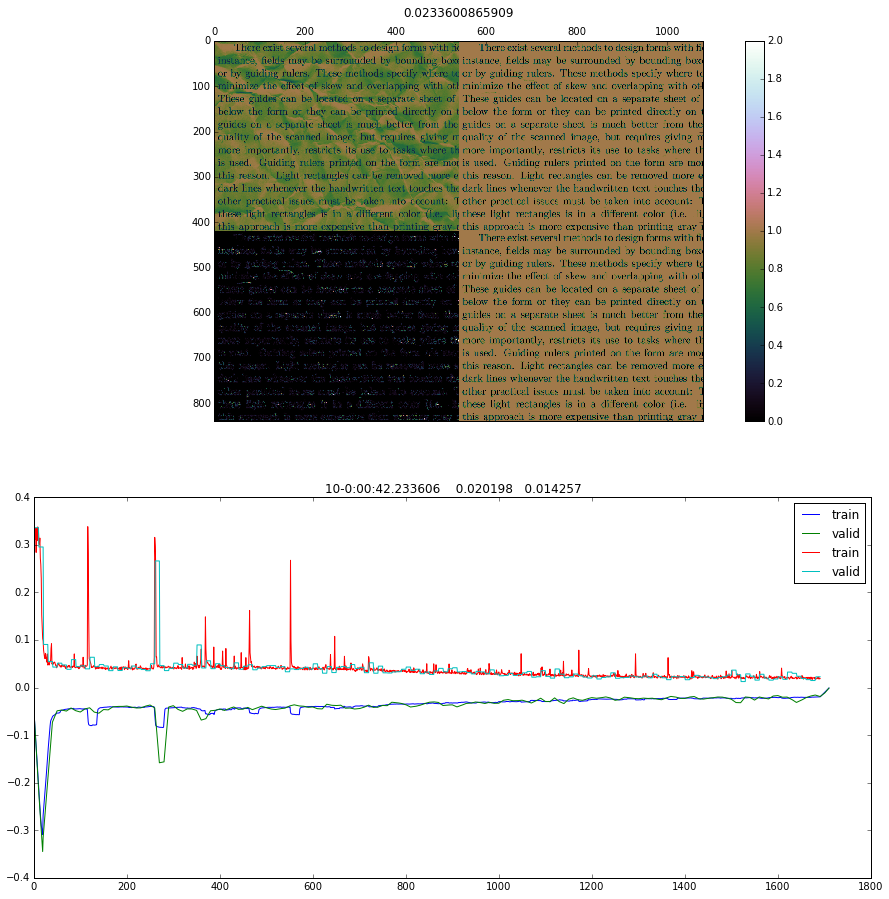

In [ ]:
i = 0
start_time = datetime.datetime.now()
while True:
    xs, ys = train_batch()
    for _ in range(10):
        trainerr = model.train_on_batch({'input': xs, 'output': ys[:, newaxis]})
    if i % 10 == 0:
        xs, ys = valid_batch()
        err = model.test_on_batch({'input': xs[:500], 'output': ys[:500, newaxis]})
        model.save_weights('keras_intraining_bigstack.hf5', overwrite=True)
        pyplot.clf()
        fig = pyplot.figure(1)
        ax1 = pyplot.subplot(211)
        runtest(ax1)
        ax2 = pyplot.subplot(212)
        ax2.plot(-scipy.signal.convolve(np.ones(20)/20, trainerrs[:]), label='train')
        ax2.plot(-scipy.signal.convolve(np.ones(20)/20, errs[:]), label='valid')
        ax2.plot(trainerrs, label='train')
        ax2.plot(errs, label='valid')
        ax2.set_ylim(-0.4, 0.4)
        ax2.legend()
        
        dt = datetime.datetime.now() - start_time
        ax2.set_title("%d-%s    %04f   %04f" % (i, dt, trainerr**0.5, err ** 0.5))
        display.clear_output(wait=True)
        display.display(pyplot.gcf())
        
        
    #if i > 500:
    #    break
    i += 1
    trainerrs.append(trainerr**0.5)
    errs.append(err**0.5)

In [ ]:
trainerrs[-40:]

<matplotlib.colorbar.Colorbar instance at 0x7f409143e758>

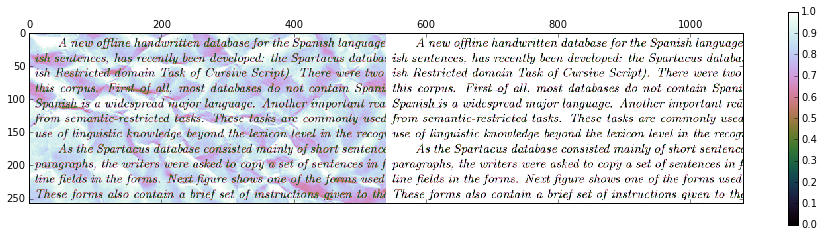

In [23]:
filename = 'test/10.png'

actual = imread(filename).astype(np.float32)
image = enlargen_image(actual)
denoised = apply_model(image, model)
pred = denoised.reshape(actual.shape)

matshow(np.concatenate([actual, pred], axis=1), cmap='cubehelix')
plt.colorbar()

In [22]:
def calculate_err(image_set, note):
    mses = []
    squared_error = 0
    n = 0

    for imname in pyprind.prog_bar(image_set):
        image = enlargen_image(imread('train/%d.png' % imname))
        cleaned = imread('train_cleaned/%d.png' % imname)
        denoised = apply_model(image, model)
        pred = denoised.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))

        squared_error += np.sum((pred - cleaned)**2)
        n += cleaned.size
        mse = sklearn.metrics.mean_squared_error(cleaned, pred)**0.5
        mses.append(mse)
    print "MSE for %s examples is %f" % (note, (squared_error / n)**0.5)
    print "Average of MSE for %s examples is %f" % (note, np.mean(mses))

calculate_err(all_valid_images, "VALIDATION")
#calculate_err(all_train_images, "TRAINING")

0%                          100%
[###############               ] | ETA[sec]: 34.477 

KeyboardInterrupt: 

# TODO

- submission
- loss function improvements
- parameter search
- deep highways and deeper nets
- more patience
- better edge detection (ie, not just a blacked out zone)

In [ ]:
entries = []
for directory, subdirs, files in os.walk('test'):
    for image in pyprind.prog_bar([f for f in files if f.endswith('.png')]):
        image_number = int(''.join([n for n in image if n.isdigit()]))
        X_image = imread(os.path.join(directory, image))
        enlarged_size = (X_image.shape[0] + patch_center*2, X_image.shape[1] + patch_center*2)
        enlargened_X = np.zeros(enlarged_size, dtype='float32')
        enlargened_X[patch_center:-patch_center, patch_center:-patch_center] = X_image
        pred = apply_model(enlargened_X, model).reshape(X_image.shape)
        imsave(os.path.join('denoised', image), pred, cmap='cubehelix')
        for row in range(pred.shape[0]):
            for col in range(pred.shape[1]):
                entries.append(("%d_%d_%d" % (image_number, row+1, col+1), pred[row, col]))

In [ ]:
import csv
import gzip
with gzip.open('submission.csv.gz', 'w', 9) as subfile:
    writer = csv.writer(subfile)
    writer.writerow(('id', 'value'))
    writer.writerows(entries)